In [15]:


!jupyter nbconvert --to html  ASE23.ipynb  --no-input --output-dir=./results/
# --to pdf, html, latex 



[NbConvertApp] Converting notebook ASE23.ipynb to html
[NbConvertApp] Writing 958373 bytes to results\ASE23.html


In [1]:


import json
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 15)

keep_metrics = ['HV', 'spread', 'unfr','time','nds_update_time']

datasets_names = ['p1', 'p2', 's1', 's2', 's3', 's4']  
algorithms = ['geneticnds', 'umda', 'pbil','mimic', 'GRASP']  #'geneticnds', 'umda', 'pbil','mimic', 'GRASP'
time_limit = 100000 # 150 (100000 is no limit)
use_best_config_in_all_datasets = True # True (original) uses the config which worked best among all datasets. False uses the best config for each dataset (and thus time_limit is respected)
values_sss = [True] # si es con los dos: [False, True]

# plots configuration
plots_type_scatter=False # True for scatter of pareto solutions, and False for joint solutions with thick lines
allParetos =False; # plot the 30 paretos, or only 1

files_container = '../output/files_list_allGRASP_Dgeneticnds-umda-pbil-mimic-GRASP' 
#'../output/files_list_allGRASP_Dgeneticnds-pbil-mimic-GRASP'
#'../output/files_list_allGRASP_GRASP-nsgaii-umda-mimic'



## 1 Datasets

In [2]:
import sys  
sys.path.insert(0, '../datasets')
from Dataset import Dataset

ds_summary = pd.DataFrame(columns=['Dataset', '#Stakeholders', '#PBI', '#(PBI-->[PBI])', '%(PBI-->[PBI])','Avg_len[PBI]'])

for name in datasets_names:
    
    ds = Dataset(source_file='../datasets/'+ name+ '.json')
    n_pbis = ds.num_pbis
    n_stakeholders = len(ds.stakeholders_importances)

    n_dependencies = sum(x is not None for x in ds.dependencies)
    ratio_pbi_with_deps =  n_dependencies / n_pbis
    avg_depends_per_pbi = 0
    for dep in ds.dependencies:
        avg_depends_per_pbi = avg_depends_per_pbi + len(dep) if dep is not None else avg_depends_per_pbi + 0
    avg_depends_per_pbi = avg_depends_per_pbi / n_dependencies
    
    new_row = {'Dataset': name, '#Stakeholders': n_stakeholders, '#PBI': n_pbis,  '#(PBI-->[PBI])': n_dependencies, '%(PBI-->[PBI])': ratio_pbi_with_deps, 'Avg_len[PBI]':avg_depends_per_pbi}
    new_row = pd.DataFrame(new_row, index=[0])
    ds_summary = pd.concat([ds_summary, new_row], ignore_index=True)

    #ds_summary = ds_summary.append(new_row, ignore_index=True)#deprecated

def row_color(val):
    
    if val < 2: color = 'background-color: yellow'

    return color


pd.set_option('display.float_format', '{:.3f}'.format)
display(ds_summary)



,Dataset,#Stakeholders,#PBI,#(PBI-->[PBI]),%(PBI-->[PBI]),Avg_len[PBI]
0,p1,5,18,4,0.222,1.750
1,p2,5,96,23,0.240,2.609
2,s1,15,40,17,0.425,1.882
3,s2,50,80,32,0.400,2.250
4,s3,100,140,51,0.364,2.078
5,s4,150,200,72,0.360,2.097


In [3]:
import math

def getdf_with_params_and_metrics(files, keep_parameters):

    parameters_dictios_list = []
    metrics_dictios_list = []
    
    
    for file in files:
        with open(file, 'r') as f:
            dictio = json.load(f)
            parameters_dictios_list.append(dictio['parameters'])
            metrics_dictios_list.append(dictio['metrics'])
        
            

    parameters_df= pd.DataFrame(parameters_dictios_list)
    parameters_df = parameters_df[['dataset'] + keep_parameters]

    metrics_df = pd.DataFrame(metrics_dictios_list)
    
    metrics_df = metrics_df[keep_metrics]
    #lists = metrics_df['gdplus']
    #for l in lists:
     #   for x in l:
      #      if isinstance(x, str): print(x, l)

    
    for column in keep_metrics: #we have several runs for each metric (list of values in each cell), so compute mean
        #metrics_df[column] = pd.DataFrame(metrics_df[column].values.tolist())
        metrics_df[column] = pd.DataFrame(metrics_df[column].values.tolist()).mean(axis=1)
    #display(metrics_df)
    combined_df=parameters_df.join(metrics_df)
    combined_df['file']=files

    return combined_df

In [4]:
import pandas as pd
import re

# Counts the number of wins (HV by default) for each configuration in data_df of the given hyperparameters.
# Each win is computed from results for a dataset
# returns:
#    dictionary with the, most frequently, best configuration. if ties, then first occurrence is returned
#    dictionary with the count of configuration which were the best at leats once
#    number of datasets    
# 
def get_best_configuration(data_df, hyperparameters, metric: str = 'HV') -> dict:
    
    dataset_groups = data_df.groupby(['dataset'])
    best_configs_counts = {}


    for group in dataset_groups: # find best hyperparameters config
        #print(group)
        group_df = pd.DataFrame(group[1])
        max_index = group_df[metric].idxmax()
        best_config = (group[1][hyperparameters]).loc[max_index]
        dataset_name = (group[1]['dataset']).loc[max_index] #any row
        file_name = (group[1]['file']).loc[max_index] 
        time = round((group[1]['time']).loc[max_index],2)
        
        key = best_config.to_string()
        besthv = round(group_df[metric].loc[max_index], 4)
        if key in best_configs_counts.keys():
            (count, list_datasets, list_hv, list_time, list_files) = best_configs_counts[key]
            list_datasets.extend([dataset_name])
            list_hv.extend([besthv])
            list_time.extend([time])
            list_files.extend([file_name])
           
            best_configs_counts[key]= (count + 1, list_datasets, list_hv, list_time, list_files)
        else:
            best_configs_counts[key] = (1, [dataset_name], [besthv], [time], [file_name])

           
    
    #print(best_configs_counts)
   # print(len(best_configs_counts))
    #print(best_configs_counts)
    v = list(best_configs_counts.values())
    k = list(best_configs_counts.keys())
    best_config = k[v.index(max(v))]

    #convert string of best config to dictionary 
    best_config = re.sub(' +',' ',best_config)
    best_config = best_config.replace(' ',':')
    best_config = best_config.replace('\n',',')
    best = dict((x.strip(), y.strip())
             for x, y in (element.split(':') 
             for element in best_config.split(',')))
    return best, best_configs_counts, len(dataset_groups)
    
        

In [5]:
# convert dictionary counts of each best configuration to dataframe
def dictionary_keystring_to_dataframe(keep_parameters, best_counts):
    table_df = pd.DataFrame(columns=keep_parameters+['datasets'])
    for k in best_counts.keys():
        #print(f"{k} \n\t\t---> was the best config in: {best_counts[k]} datasets")
        row_dict = dict()
        for col in keep_parameters:
            start=k.index(col+' ')
            try: 
                end=k.index("\n", start)
            except: end = len(k)
            line = k[start:end]
            key = line[0:line.index(' ')]
            value = line[line.rfind(' ')+1:len(line)]
            row_dict[key]=value
        (counts, datasets_names, HVs, times, file_example) = best_counts[k]
        row_dict['datasets'] = datasets_names
        row_dict['HV'] = HVs
        row_dict['time'] = times
        row_dict['wins'] = int(counts)
        row_dict['file'] = file_example
        table_df = table_df.append(row_dict, ignore_index=True)
    return table_df

In [6]:
def print_hyperparams_values(df, hyperparmeters, algorithm):
    print(f"These are the different values used to set hyperparameters in {algorithm}, for each dataset:")
    mult = 1
    for hp in hyperparmeters:
        values = df[hp].unique()
        mult = mult * len(values)
        print(f"{hp}: {values}")
    print(f"In total, {mult} configuration per dataset.")

In [7]:
# create list of files with best configuration for a given algorithm
def get_files_list_with_best_configuration(best_for_algorithm_df, datasets_list):
    best_for_algorithm_df['wins'] = best_for_algorithm_df['wins'].astype(int)
    max_index = best_for_algorithm_df['wins'].idxmax()
    file_template = best_for_algorithm_df['file'].loc[max_index][0] #0 or any other if there is more than one file
    dataset_in_template =  best_for_algorithm_df['datasets'].loc[max_index][0]
    algorithm_files = [] #ordered by datasetname
    for dataset in datasets_list:
        file = file_template.replace(dataset_in_template, dataset, 1)
        algorithm_files.extend([file])
    return algorithm_files


In [8]:
def get_files_for_dataset(dataset_name):
    files = []
    with open(files_container, 'r') as f:
        for line in f:
            # todo: al haber metido en files_list los geneticos, resulta que tienen "p1" en todos los nombres por 'flip1bit', y elitismnds30 con s3.
            temp_line = line.replace("flip1bit", '')
            temp_line = temp_line.replace("elitismnds30", '')
            if dataset_name in temp_line: 
                files.append('../'+str(line.replace('\n','')))
    return files

## 2 Search of the best hyperparameters configuration for each algorithm, given SSS_per_iteration={False,True}

In [9]:
keep_parameters_random = ['population_length', 'max_generations']
keep_parameters_feda = ['population_length', 'max_generations', 'selection_scheme'] 
keep_parameters_GRASP = ['solutions_per_iteration', 'iterations', 'init_type', 'local_search_type', 'path_relinking_mode','sss_per_iteration']
keep_parameters_geneticnds = ['population_length', 'max_generations', 'selection_candidates', 'crossover_prob', 'mutation_prob', 'mutation', 'replacement','sss_per_iteration']
keep_parameters_umda = ['population_length', 'max_generations', 'selection_scheme', 'replacement_scheme','sss_per_iteration']
keep_parameters_pbil = ['population_length', 'max_generations','max_evaluations', 'learning_rate', 'mutation_prob','mutation_shift','sss_per_iteration']
keep_parameters_mimic = ['population_length', 'max_generations','max_evaluations', 'selection_scheme', 'selected_individuals','sss_per_iteration']
keep_parameters_nsgaiipt = ['population_length', 'max_generations', 'selection_candidates', 'crossover_prob', 'mutation_prob', 'mutation', 'replacement']

display_drop_feda = ['file','selection_scheme']
display_drop_nsgaiipt = ['file','selection_candidates','crossover_prob', 'mutation', 'replacement']
display_drop_pbil=['file', 'learning_rate','mutation_prob', 'max_evaluations','mutation_shift']
display_drop_umda=['file', 'replacement_scheme','selection_scheme']
display_drop_random=['file']
display_drop_GRASP=['file']
display_drop_mimic=['file', 'max_evaluations', 'selection_scheme','selected_individuals']
display_drop_geneticnds=['file','selection_candidates','crossover_prob', 'mutation', 'replacement']



for algorithm in algorithms:
    print("-----------------------------------------------------")
    print("SEARCH OF BEST CONFIGURATION FOR: ", algorithm)
    print("-----------------------------------------------------")
   
    files = []
    with open(files_container, 'r') as f:
        for line in f:
            if algorithm in line:
                files.append('../'+str(line.replace('\n','')))

    print(datasets_names)
    keep_parameters_alg = globals()['keep_parameters_'+algorithm]
    
    df_alg = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters_alg)
    df_alg = df_alg[df_alg.dataset.isin(datasets_names)]
    if algorithm=='GRASP':
        display(df_alg)
    print_hyperparams_values(df_alg, keep_parameters_alg, algorithm)
    #display(df_feda)

   
    globals()['best_config_'+algorithm], best_counts, ndatasets= get_best_configuration(data_df=df_alg, hyperparameters=keep_parameters_alg, metric='HV')
    globals()['best_for_'+algorithm+'_df']=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters_alg, best_counts=best_counts)

    best_for_alg_df =  globals()['best_for_'+algorithm+'_df']
    best_config_alg = globals()['best_config_'+algorithm]
    print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
        "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
        "can be interpreted as 'minimum configuration to converge'.")
    with pd.option_context('display.max_colwidth', None):
        display(best_for_alg_df.drop(['file'], axis=1, inplace=False))

    print(f"\nBest hyperparameter configuration for ", algorithm," is:")
    for param in best_config_alg:
        print(f"{param}:{best_config_alg[param]}")

    pd.set_option('display.float_format', '{:.3f}'.format)
    display_drop_alg =globals()['display_drop_'+algorithm]
    with pd.option_context('display.max_colwidth', None):
        print((best_for_alg_df.drop(display_drop_alg, axis=1)).to_latex(index=False))

-----------------------------------------------------
SEARCH OF BEST CONFIGURATION FOR:  geneticnds
-----------------------------------------------------
['p1', 'p2', 's1', 's2', 's3', 's4']
These are the different values used to set hyperparameters in geneticnds, for each dataset:
population_length: [700]
max_generations: [400]
selection_candidates: [2]
crossover_prob: [0.8]
mutation_prob: [0.1]
mutation: ['flip1bit']
replacement: ['elitismnds']
sss_per_iteration: [ True]
In total, 1 configuration per dataset.

Counts of best configurations found in 6 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,selection_candidates,crossover_prob,mutation_prob,mutation,replacement,sss_per_iteration,datasets,HV,time,wins
0,700,400,2,0.800,0.100,flip1bit,elitismnds,True,"[p1, p2, s1, s2, s3, s4]","[0.8858, 0.6892, 0.7606, 0.6643, 0.6539, 0.6229]","[136.44, 272.03, 213.32, 248.39, 310.25, 322.96]",6.000



Best hyperparameter configuration for  geneticnds  is:
population_length:700
max_generations:400
selection_candidates:2
crossover_prob:0.800
mutation_prob:0.100
mutation:flip1bit
replacement:elitismnds
sss_per_iteration:True
\begin{tabular}{lllllllr}
\toprule
population\_length & max\_generations & mutation\_prob & sss\_per\_iteration &                 datasets &                                               HV &                                             time &  wins \\
\midrule
              700 &             400 &         0.100 &              True & [p1, p2, s1, s2, s3, s4] & [0.8858, 0.6892, 0.7606, 0.6643, 0.6539, 0.6229] & [136.44, 272.03, 213.32, 248.39, 310.25, 322.96] & 6.000 \\
\bottomrule
\end{tabular}

-----------------------------------------------------
SEARCH OF BEST CONFIGURATION FOR:  umda
-----------------------------------------------------
['p1', 'p2', 's1', 's2', 's3', 's4']
These are the different values used to set hyperparameters in umda, for each dataset:
pop

,population_length,max_generations,selection_scheme,replacement_scheme,sss_per_iteration,datasets,HV,time,wins
0,700,400,nds,elitism,True,"[p1, p2, s1, s2, s3, s4]","[0.894, 0.7746, 0.8354, 0.7447, 0.748, 0.7239]","[336.63, 1006.43, 674.64, 1306.62, 1892.57, 1731.56]",6.000



Best hyperparameter configuration for  umda  is:
population_length:700
max_generations:400
selection_scheme:nds
replacement_scheme:elitism
sss_per_iteration:True
\begin{tabular}{llllllr}
\toprule
population\_length & max\_generations & sss\_per\_iteration &                 datasets &                                             HV &                                                 time &  wins \\
\midrule
              700 &             400 &              True & [p1, p2, s1, s2, s3, s4] & [0.894, 0.7746, 0.8354, 0.7447, 0.748, 0.7239] & [336.63, 1006.43, 674.64, 1306.62, 1892.57, 1731.56] & 6.000 \\
\bottomrule
\end{tabular}

-----------------------------------------------------
SEARCH OF BEST CONFIGURATION FOR:  pbil
-----------------------------------------------------
['p1', 'p2', 's1', 's2', 's3', 's4']
These are the different values used to set hyperparameters in pbil, for each dataset:
population_length: [700]
max_generations: [400]
max_evaluations: [0]
learning_rate: [0.1]
mutati

,population_length,max_generations,max_evaluations,learning_rate,mutation_prob,mutation_shift,sss_per_iteration,datasets,HV,time,wins
0,700,400,0,0.100,0.100,0.100,True,"[p1, p2, s1, s2, s3, s4]","[0.9078, 0.7635, 0.8635, 0.7265, 0.6987, 0.6321]","[209.59, 189.38, 221.29, 266.62, 196.24, 203.89]",6.000



Best hyperparameter configuration for  pbil  is:
population_length:700
max_generations:400
max_evaluations:0
learning_rate:0.100
mutation_prob:0.100
mutation_shift:0.100
sss_per_iteration:True
\begin{tabular}{llllllr}
\toprule
population\_length & max\_generations & sss\_per\_iteration &                 datasets &                                               HV &                                             time &  wins \\
\midrule
              700 &             400 &              True & [p1, p2, s1, s2, s3, s4] & [0.9078, 0.7635, 0.8635, 0.7265, 0.6987, 0.6321] & [209.59, 189.38, 221.29, 266.62, 196.24, 203.89] & 6.000 \\
\bottomrule
\end{tabular}

-----------------------------------------------------
SEARCH OF BEST CONFIGURATION FOR:  mimic
-----------------------------------------------------
['p1', 'p2', 's1', 's2', 's3', 's4']
These are the different values used to set hyperparameters in mimic, for each dataset:
population_length: [700]
max_generations: [400]
max_evaluations: [0

,population_length,max_generations,max_evaluations,selection_scheme,selected_individuals,sss_per_iteration,datasets,HV,time,wins
0,700,400,0,nds,50,True,"[p1, p2, s1, s2, s3, s4]","[0.7436, 0.7995, 0.8493, 0.7267, 0.7581, 0.723]","[405.75, 2726.68, 1199.21, 2593.09, 2871.16, 1839.38]",6.000



Best hyperparameter configuration for  mimic  is:
population_length:700
max_generations:400
max_evaluations:0
selection_scheme:nds
selected_individuals:50
sss_per_iteration:True
\begin{tabular}{llllllr}
\toprule
population\_length & max\_generations & sss\_per\_iteration &                 datasets &                                              HV &                                                  time &  wins \\
\midrule
              700 &             400 &              True & [p1, p2, s1, s2, s3, s4] & [0.7436, 0.7995, 0.8493, 0.7267, 0.7581, 0.723] & [405.75, 2726.68, 1199.21, 2593.09, 2871.16, 1839.38] & 6.000 \\
\bottomrule
\end{tabular}

-----------------------------------------------------
SEARCH OF BEST CONFIGURATION FOR:  GRASP
-----------------------------------------------------
['p1', 'p2', 's1', 's2', 's3', 's4']


,dataset,solutions_per_iteration,iterations,init_type,local_search_type,path_relinking_mode,sss_per_iteration,HV,spread,unfr,time,nds_update_time,file
0,p1,700,400,stochastically,None,None,True,0.894,0.596,0.231,292.171,143.542,../output/GRASP/GRASPTruep15100True4007000stoc...
1,p1,700,400,stochastically,best_first_neighbor_random,None,True,0.490,0.817,0.286,266.492,26.432,../output/GRASP/GRASPTruep15100True4007000stoc...
2,p1,700,400,stochastically,best_first_neighbor_sorted_score,None,True,0.490,0.820,0.286,261.403,26.501,../output/GRASP/GRASPTruep15100True4007000stoc...
3,p1,700,400,stochastically,best_first_neighbor_sorted_score_r,None,True,0.301,0.939,0.080,545.593,3.632,../output/GRASP/GRASPTruep15100True4007000stoc...
4,p1,700,400,stochastically,best_first_neighbor_random_domination,None,True,0.894,0.608,0.232,365.666,143.624,../output/GRASP/GRASPTruep15100True4007000stoc...
5,p1,700,400,stochastically,best_first_neighbor_sorted_domination,None,True,0.894,0.596,0.231,364.648,144.961,../output/GRASP/GRASPTruep15100True4007000stoc...
6,p1,700,400,stochastically,local_search_bitwise_bestFirst_HV,None,True,0.755,0.658,0.193,3494.653,4.241,../output/GRASP/GRASPTruep15100True4007000stoc...
7,p1,700,400,stochastically,None,after_local,True,0.908,0.532,0.250,757.335,253.411,../output/GRASP/GRASPTruep15100True4007000stoc...
8,p1,700,400,stochastically,best_first_neighbor_random,after_local,True,0.490,0.818,0.286,437.591,53.667,../output/GRASP/GRASPTruep15100True4007000stoc...
9,p1,700,400,stochastically,best_first_neighbor_sorted_score,after_local,True,0.490,0.826,0.286,470.440,57.460,../output/GRASP/GRASPTruep15100True4007000stoc...


These are the different values used to set hyperparameters in GRASP, for each dataset:
solutions_per_iteration: [700]
iterations: [400]
init_type: ['stochastically']
local_search_type: ['None' 'best_first_neighbor_random' 'best_first_neighbor_sorted_score'
 'best_first_neighbor_sorted_score_r'
 'best_first_neighbor_random_domination'
 'best_first_neighbor_sorted_domination'
 'local_search_bitwise_bestFirst_HV']
path_relinking_mode: [None 'after_local']
sss_per_iteration: [ True]
In total, 14 configuration per dataset.

Counts of best configurations found in 6 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,solutions_per_iteration,iterations,init_type,local_search_type,path_relinking_mode,sss_per_iteration,datasets,HV,time,wins
0,700,400,stochastically,best_first_neighbor_random_domination,after_local,True,"[p1, p2, s1, s2, s3, s4]","[0.9078, 0.8572, 0.8692, 0.7888, 0.8432, 0.8141]","[928.64, 7842.5, 2347.99, 6678.57, 16530.27, 34170.7]",6.000



Best hyperparameter configuration for  GRASP  is:
solutions_per_iteration:700
iterations:400
init_type:stochastically
local_search_type:best_first_neighbor_random_domination
path_relinking_mode:after_local
sss_per_iteration:True
\begin{tabular}{lllllllllr}
\toprule
solutions\_per\_iteration & iterations &      init\_type &                     local\_search\_type & path\_relinking\_mode & sss\_per\_iteration &                 datasets &                                               HV &                                                  time &  wins \\
\midrule
                    700 &        400 & stochastically & best\_first\_neighbor\_random\_domination &         after\_local &              True & [p1, p2, s1, s2, s3, s4] & [0.9078, 0.8572, 0.8692, 0.7888, 0.8432, 0.8141] & [928.64, 7842.5, 2347.99, 6678.57, 16530.27, 34170.7] & 6.000 \\
\bottomrule
\end{tabular}



## 3 Plots of algorithms' NDS with their best configuration

In [10]:
# create list of files with best configuration for a given algorithm
def get_files_list_with_best_configuration(best_for_algorithm_df, datasets_list):
    best_for_algorithm_df['wins'] = best_for_algorithm_df['wins'].astype(int)
    max_index = best_for_algorithm_df['wins'].idxmax()
    file_template = best_for_algorithm_df['file'].loc[max_index][0] #0 or any other if there is more than one file
    dataset_in_template =  best_for_algorithm_df['datasets'].loc[max_index][0]
    algorithm_files = [] #ordered by datasetname
    for dataset in datasets_list:
        file = file_template.replace(dataset_in_template, dataset, 1)
        algorithm_files.extend([file])
    return algorithm_files
    
    


In [11]:

def get_files_list_with_best_configuration_per_dataset(alg_name, sss_per_it=False):
    it = values_sss.index(sss_per_it)
    #it = 1 if sss_per_it==True else it
    

    if alg_name=='GRASP':
        df_with_bests = best_for_grasp_df[it]
    if alg_name=='umda':
        df_with_bests = best_for_umda_df[it]
    if alg_name=='pbil':
        df_with_bests = best_for_pbil_df[it]
    if alg_name=='geneticNDS':
        df_with_bests = best_for_geneticnds_df[it]
    if alg_name=='mimic':
        df_with_bests = best_for_mimic_df[it]
    if alg_name=='nsgaii':
        df_with_bests = best_for_nsgaii_df[0] #not done with SSS per it

    algorithm_files = [] #ordered by datasetname
    for dataset in datasets_names:
        try:
            best_conf_row = df_with_bests.loc[df_with_bests['datasets'].apply(lambda x: dataset in x)].iloc[0]
            position = best_conf_row['datasets'].index(dataset)
            file = best_conf_row.file[position]
            algorithm_files.extend([file])
        except: print(f"not best file yet for {dataset} for algorithm {alg_name}")
    
    return algorithm_files
    


In [12]:
import matplotlib as plt
def get_order_xy_points(solutions):
    x = [item[0] for item in solutions]
    y = [1-item[1] for item in solutions] #revert satisfaction. 0,0 is best point
        
    tuples = list(zip(x,y))
    tuples.sort()
    x = list(zip(*tuples))[0]
    y = list(zip(*tuples))[1]
    return x,y
    
    

p1
Pareto Reference has 28 points
Maximum UNFR possible is 10/28=0.3571


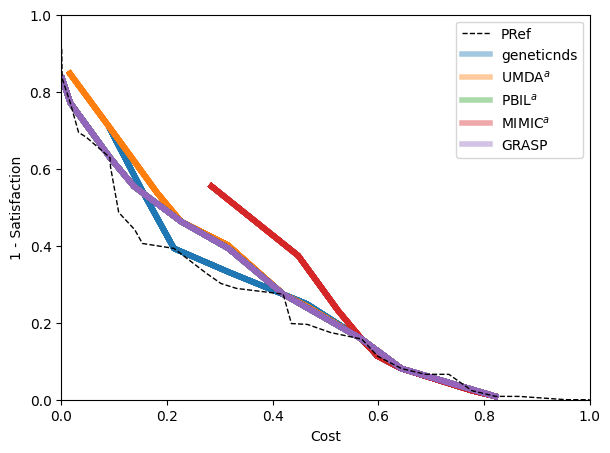

,Method,HV,UNFR,gd+,spread,time(s),|NDS|
0,geneticnds,0.8858,0.1702,0.0279,0.6380,136.4355,10.0000
1,umda,0.8940,0.1786,0.0302,0.6506,336.6274,10.0000
2,pbil,0.9078,0.2488,0.0194,0.5345,209.5871,10.0000
3,mimic,0.7436,0.2500,0.0339,0.8260,405.7460,10.0000
4,GRASP,0.9078,0.2500,0.0193,0.5324,928.6382,10.0000


---------------------------------------------------------------
p2
Pareto Reference has 264 points
Maximum UNFR possible is 10/264=0.0379


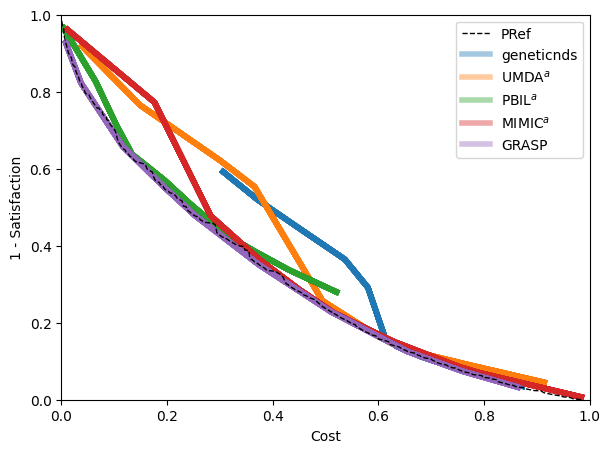

,Method,HV,UNFR,gd+,spread,time(s),|NDS|
0,geneticnds,0.6892,0.0087,0.0574,0.7101,272.0327,10.0000
1,umda,0.7746,0.0030,0.0428,0.6101,1006.4337,10.0000
2,pbil,0.7635,0.0024,0.0181,0.5907,189.3832,10.0000
3,mimic,0.7995,0.0009,0.0193,0.6174,2726.6786,10.0000
4,GRASP,0.8572,0.0275,0.0006,0.6415,7842.4970,10.0000


---------------------------------------------------------------
s1
Pareto Reference has 106 points
Maximum UNFR possible is 10/106=0.0943


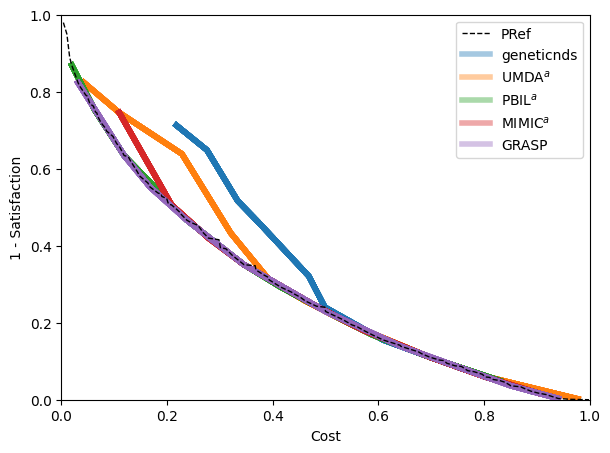

,Method,HV,UNFR,gd+,spread,time(s),|NDS|
0,geneticnds,0.7606,0.0415,0.0382,0.6427,213.3205,10.0000
1,umda,0.8354,0.0478,0.0176,0.6177,674.6405,10.0000
2,pbil,0.8635,0.0827,0.0007,0.6535,221.2865,10.0000
3,mimic,0.8493,0.0742,0.0048,0.5440,1199.2104,10.0000
4,GRASP,0.8692,0.0943,0.0000,0.6193,2347.9870,10.0000


---------------------------------------------------------------
s2
Pareto Reference has 326 points
Maximum UNFR possible is 10/326=0.0307


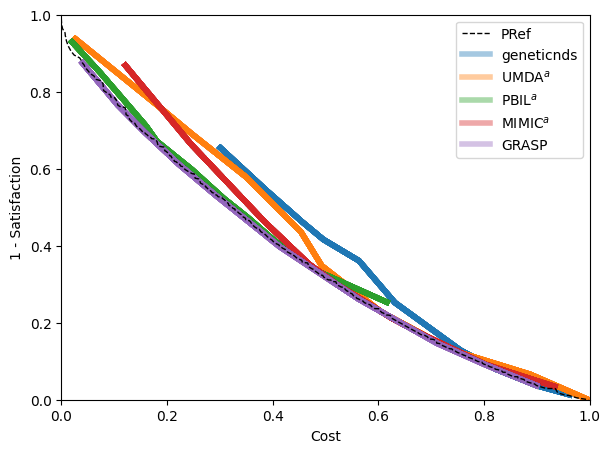

,Method,HV,UNFR,gd+,spread,time(s),|NDS|
0,geneticnds,0.6643,0.0066,0.0398,0.6338,248.3893,10.0000
1,umda,0.7447,0.0082,0.0267,0.5788,1306.6225,10.0000
2,pbil,0.7265,0.0066,0.0078,0.5966,266.6199,10.0000
3,mimic,0.7267,0.0092,0.0144,0.6509,2593.0856,10.0000
4,GRASP,0.7888,0.0266,0.0004,0.6131,6678.5743,10.0000


---------------------------------------------------------------
s3
Pareto Reference has 367 points
Maximum UNFR possible is 10/367=0.0272


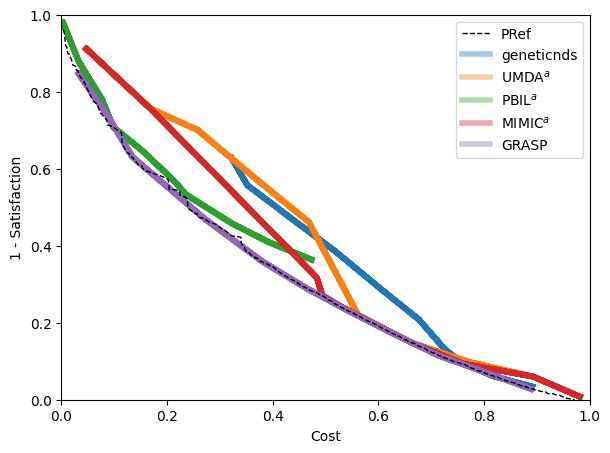

,Method,HV,UNFR,gd+,spread,time(s),|NDS|
0,geneticnds,0.6539,0.0045,0.0659,0.6556,310.2456,10.0000
1,umda,0.7480,0.0033,0.0505,0.6190,1892.5718,10.0000
2,pbil,0.6987,0.0005,0.0281,0.5730,196.2353,10.0000
3,mimic,0.7581,0.0069,0.0278,0.6166,2871.1561,10.0000
4,GRASP,0.8432,0.0184,0.0010,0.6356,16530.2699,10.0000


---------------------------------------------------------------
s4
Pareto Reference has 351 points
Maximum UNFR possible is 10/351=0.0285


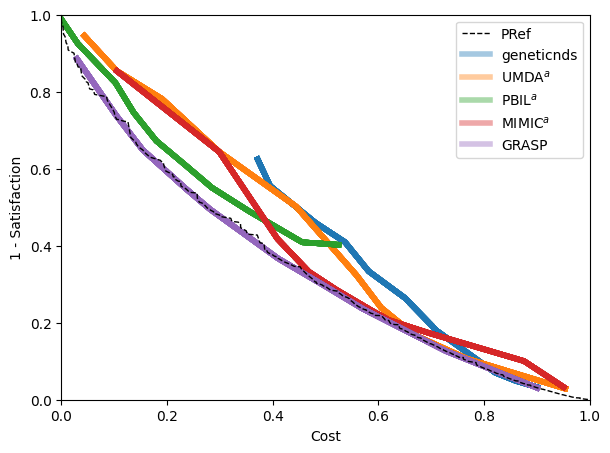

,Method,HV,UNFR,gd+,spread,time(s),|NDS|
0,geneticnds,0.6229,0.0028,0.0627,0.6593,322.9554,10.0000
1,umda,0.7239,0.0039,0.0473,0.5869,1731.5583,10.0000
2,pbil,0.6321,0.0003,0.0323,0.5703,203.8927,10.0000
3,mimic,0.7230,0.0018,0.0309,0.6421,1839.3813,10.0000
4,GRASP,0.8142,0.0156,0.0017,0.6275,34170.6979,10.0000


---------------------------------------------------------------
Wins Counts:
{'geneticnds': 0, 'umda': 0, 'pbil': 1, 'mimic': 0, 'GRASP': 5}
Wins in datasets:
{'geneticnds': [], 'umda': [], 'pbil': ['p1'], 'mimic': [], 'GRASP': ['p2', 's1', 's2', 's3', 's4']}
Wins Counts UNFR:
{'geneticnds': 0, 'umda': 0, 'pbil': 0, 'mimic': 1, 'GRASP': 5}
Wins Counts GD+:
{'geneticnds': 0, 'umda': 0, 'pbil': 0, 'mimic': 0, 'GRASP': 6}
Wins Counts Spread:
{'geneticnds': 0, 'umda': 1, 'pbil': 3, 'mimic': 1, 'GRASP': 1}


In [13]:
from pymoo.visualization.scatter import Scatter
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


#display(best_for_grasp_df)
files_all_algorithms=[]

if use_best_config_in_all_datasets:
    for alg in algorithms:
        files_all_algorithms = files_all_algorithms + [get_files_list_with_best_configuration(globals()['best_for_'+alg+'_df'], datasets_names)]


else: #use best config for each dataset in each algorithm
    for alg in algorithms:
        files_all_algorithms = files_all_algorithms + [get_files_list_with_best_configuration_per_dataset(alg_name=alg)]




wins_counts = {}
wins_counts_unfr = {}
wins_counts_gd = {}
wins_counts_spread = {}
wins_datasets = {}
for alg in algorithms:
    wins_counts[alg] = 0
    wins_datasets[alg] = []
    wins_counts_unfr[alg] = 0
    wins_counts_gd[alg] = 0
    wins_counts_spread[alg] = 0
 

# print 30 (or the number of execution) paretos of each dataset

latex_df = pd.DataFrame(columns=["Method","HV","UNFR","gd+","spread","time(s)","|NDS|"])

#store results for statistical tests
friedman_HV_input = [[0 for _ in range(len(datasets_names))] for _ in range(len(algorithms))] # almacenar HV: algorithmos en filas, datasets en columnas
friedman_unfr_input = [[0 for _ in range(len(datasets_names))] for _ in range(len(algorithms))] 
friedman_gdplus_input = [[0 for _ in range(len(datasets_names))] for _ in range(len(algorithms))] 
friedman_spread_input = [[0 for _ in range(len(datasets_names))] for _ in range(len(algorithms))] 
friedman_nds_input = [[0 for _ in range(len(datasets_names))] for _ in range(len(algorithms))] 


for i in range(0,len(datasets_names)):
    fig = plt.figure(figsize=(15,5)) #20,5 when plotting also ax2 with table
    #ax =fig.add_axes([0,0,1,1])
    ax = fig.add_subplot(121)
    ax.set_xlabel(xlabel='Cost')
    ax.set_ylabel(ylabel='1 - Satisfaction')
    print(datasets_names[i])
   # ax.set_title(datasets_names[i])
    plt.xlim(left=0,right=1)
    plt.ylim(bottom=0,top=1)

    
    
    summary_df = pd.DataFrame(columns=["Method","HV","UNFR","gd+","spread","time(s)","|NDS|"])
    
    for j in range(0,len(algorithms)):    
        try:
            file = files_all_algorithms[j][i] #they are ordered by dataset list initiated in first cell
            with open(file, 'r') as f:
                dictio = json.load(f)
            paretos_list = dictio['paretos']
            dataset = dictio['parameters']['dataset']
            metrics = dictio['metrics']
            pareto_reference = dictio['Reference_Pareto'] # any algorithm j has/should have the same PR for the same dataset. we use the last (same) after this loop
            
            (hv, unfr, gdplus, spread, time, nds) = (metrics['HV'], metrics['unfr'], metrics['gdplus'],metrics['spread'], metrics['time'], metrics['NDS_size'])
            dec=6
            new_row = {'Method': algorithms[j], 'HV':np.mean(hv).round(decimals=dec), 'UNFR':np.mean(unfr).round(decimals=dec), 'gd+':np.mean(gdplus).round(decimals=4),
             'spread':np.mean(spread).round(decimals=dec), 'time(s)':np.mean(time).round(decimals=dec), '|NDS|':np.mean(nds).round(decimals=dec)}
            friedman_HV_input[j][i] = new_row['HV']
            friedman_unfr_input[j][i] = new_row['UNFR']
            friedman_gdplus_input[j][i] = new_row['gd+']
            friedman_spread_input[j][i] = new_row['spread']
            friedman_nds_input[j][i] = new_row['|NDS|']
            

            
            for pareto in paretos_list: 
                if allParetos==False:
                    pareto=paretos_list[0]
    
                if plots_type_scatter==False:
                    x,y = get_order_xy_points(pareto)
                    plt.plot(x,y, linestyle="-", alpha=0.4,linewidth=4, color='C'+str(j),label=algorithms[j])
                else:    
                    x = [item[0] for item in pareto]
                    y = [1-item[1] for item in pareto] #revert satisfaction. 0,0 is best point
                    plt.scatter(x=x, y=y, color='C'+str(j), alpha=0.4, edgecolors='none', label=algorithms[j], marker='o') # commonly 10 points (subset size in soluction subset selection)
                    
            
            #summary_df = summary_df.append(new_row, ignore_index=True)
            new_row = pd.DataFrame(new_row, index=[0])
            summary_df = pd.concat([summary_df, new_row], ignore_index=True)
        except(FileNotFoundError, IOError):
            print(file, f"tried to be used due to {algorithms[j]} best configuration in this dataset, but file is not available yet")
        
    
    # update wins counts in HV
    idx = summary_df['HV'].idxmax()
    winner = summary_df.loc[idx]['Method']
    wins_counts[winner] = wins_counts[winner] + 1
    wins_datasets[winner].extend([datasets_names[i]])

    # update wins counts in UNFR
    idx_unfr = summary_df['UNFR'].idxmax()
    winner_unfr = summary_df.loc[idx_unfr]['Method']
    wins_counts_unfr[winner_unfr] = wins_counts_unfr[winner_unfr] + 1
    

    # update wins counts in gd+
    idx_gd = summary_df['gd+'].idxmin()
    winner_gd = summary_df.loc[idx_gd]['Method']
    wins_counts_gd[winner_gd] = wins_counts_gd[winner_gd] + 1


    # update wins counts in spread
    idx_spread = summary_df['spread'].idxmin()
    winner_spread = summary_df.loc[idx_spread]['Method']
    wins_counts_spread[winner_spread] = wins_counts_spread[winner_spread] + 1

    # print pareto reference
    print(f"Pareto Reference has {len(pareto_reference)} points")
    max_unfr = len(pareto) / len(pareto_reference)
    print(f"Maximum UNFR possible is {len(pareto)}/{len(pareto_reference)}={max_unfr:.4f}")
    x = [item[0] for item in pareto_reference]
    y = [1-item[1] for item in pareto_reference] #revert satisfaction. 0,0 is best point
    
    tuples = list(zip(x,y))
    tuples.sort()
    x = list(zip(*tuples))[0]
    y = list(zip(*tuples))[1]
    
    #plt.scatter(x, y, color='black', alpha=0.3, edgecolors='none', label='ParetoRef', marker='_') 
    x,y = get_order_xy_points(pareto_reference)
    plt.plot(x,y, linestyle="--", linewidth=1, color='black')


    handles, labels = plt.gca().get_legend_handles_labels() #remove repeated labels, since each label=j is repeated for all paretos of the 30 executions
    by_label = dict(zip(labels, handles))
    values = list(by_label.values())
    values = [Line2D([0], [0], color='black', linestyle='--',linewidth=1, label='PRef')] + values
    legend_keys = by_label.keys()
    legend_keys=[r"RANDOM" if s =="random" else s for s in legend_keys]
    legend_keys=[r"GA$^a$" if s =="geneticNDS" else s for s in legend_keys]
    legend_keys=[r"UMDA$^a$" if s =="umda" else s for s in legend_keys]
    legend_keys=[r"PBIL$^a$" if s =="pbil" else s for s in legend_keys]
    legend_keys=[r"MIMIC$^a$" if s =="mimic" else s for s in legend_keys]
    legend_keys=[r"NSGAII-PT$^a$" if s =="nsgaiipt" else s for s in legend_keys]
    legend_keys=[r"FEDA" if s =="feda" else s for s in legend_keys]
    legend_keys= ["PRef"] + legend_keys

    plt.legend(values,legend_keys )        
    #plt.legend(by_label.values(), ["GA", "UMDA", "PBIL", "FEDA","ParetoRef"])        
    


    plt.savefig("images/linePareto0_"+datasets_names[i]+".svg")
    plt.show()
    pd.set_option('display.float_format', '{:.4f}'.format)
    display(summary_df) # print in copy-paste format
    latex_df = pd.concat([latex_df,summary_df])
    
    print("---------------------------------------------------------------")
    

latex_df = latex_df.drop(columns=['time(s)'])
print("Wins Counts:") 
print(wins_counts)
print("Wins in datasets:")
print(wins_datasets)

print("Wins Counts UNFR:") 
print(wins_counts_unfr)
print("Wins Counts GD+:") 
print(wins_counts_gd)
print("Wins Counts Spread:") 
print(wins_counts_spread)

#print(friedman_HV_input)
             
